In [21]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn import model_selection
from collections import Counter
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import os


In [22]:
MAIN_PATH = os.path.dirname(os.getcwd())
DATA_PATH = MAIN_PATH + "/data/result_df.csv"

MAX_SEQUENCE_LENGTH = 32
METRIC = ["EDA", "TEMP", "BVP", "ACC_X", "ACC_Y", "ACC_Z"]

## Methods for Plotting with Matplotlib

In this section, we define methods to visualize data distributions using Matplotlib. These methods help in understanding the class distribution before and after applying SMOTE, as well as the distribution of datasets across training, validation, and test sets.

### Plotting Class Distribution Before and After SMOTE

The `plot_smote_class_distribution` function plots the class distribution of the training labels before and after applying SMOTE (Synthetic Minority Over-sampling Technique). This visualization helps in understanding how SMOTE balances the class distribution.


### Plotting Dataset Distribution

The `plot_dataset_distribution` function plots a bar chart showing the sizes of the train, validation, and test sets. This visualization helps in understanding the distribution of samples across different datasets.

These methods provide visual insights into the data, which is crucial for understanding and improving the performance of machine learning models.

In [59]:
def plot_smote_class_distribution(y_train, y_train_resampled):
    """
    Plots the class distribution before and after applying SMOTE.

    Parameters:
    - y_train: Original training labels.
    - y_train_resampled: Training labels after applying SMOTE.
    """
    # Class distribution before SMOTE
    class_distribution_before = Counter(y_train)
    # Class distribution after SMOTE
    class_distribution_after = Counter(y_train_resampled)

    # Define labels
    labels = ['No Stress', 'Stress']

    # Plotting
    plt.figure(figsize=(10, 5))

    # Plot before SMOTE
    plt.subplot(1, 2, 1)
    plt.bar(labels, class_distribution_before.values(), color='blue')
    plt.title('Class Distribution Before SMOTE')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks([0, 1], labels)

    # Plot after SMOTE
    plt.subplot(1, 2, 2)
    plt.bar(labels, class_distribution_after.values(), color='green')
    plt.title('Class Distribution After SMOTE')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks([0, 1], labels)

    plt.tight_layout()
    plt.show()
    

In [150]:
def plot_dataset_distribution(x_train, y_train, y_val_subject_1, y_val_subject_2, x_test, y_test, feature):
    dataset_names = ['Train', 'Test', 'Validation Subject 1', 'Validation Subject 2']
    
    # Calculate lengths for x and y datasets
    x_lengths = [len(x_train[feature]), len(x_test[feature]), len(y_val_subject_1), len(y_val_subject_2)]
    y_lengths = [len(y_train), len(y_test), len(y_val_subject_1), len(y_val_subject_2)]
    
    # Plotting the bar plot
    plt.figure(figsize=(10, 6))
    
    bar_width = 0.35  # Width of the bars
    
    index = np.arange(len(dataset_names))
    
    # Create bar plots for x and y datasets
    plt.bar(index, x_lengths, bar_width, color='b', alpha=0.6, label=f'X (Feature: {feature})')
    plt.bar(index + bar_width, y_lengths, bar_width, color='r', alpha=0.6, label='Y (Labels)')
    
    plt.xlabel('Dataset')
    plt.ylabel('Number of Samples')
    plt.title('Dataset Distribution')
    plt.xticks(index + bar_width / 2, dataset_names)
    plt.legend()
    
    
    plt.show()

In [25]:
def read_chunk(file_path, chunk_size=100000, usecols=None, dtype=None):
    """Reads a CSV file in chunks, adds a subject_id column, and returns a list of DataFrames for each chunk."""
    dataframes = []
    try:
        # Read the CSV in chunks
        for chunk in pd.read_csv(file_path, chunksize=chunk_size, usecols=usecols, dtype=dtype):
            dataframes.append(chunk)
    except Exception as e:
        print(f"Error reading chunks from {file_path}: {e}")
    return dataframes

In [26]:
def load_data(subjects, sensors=("wrist"), chunk_size=100000, usecols=None, dtype=None):
    """Load data from multiple CSV files in chunks and concatenate them into a single DataFrame."""
    dataframes = []
        # Create file paths for each subject and sensor
    file_paths = [MAIN_PATH + f"/data/unprocessed/WESAD/{subject}/{sensors}/{subject}.csv" for subject in subjects]
    total_files = len(file_paths)

    # Use a thread pool to read files in chunks in parallel
    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(read_chunk, file_path, chunk_size, usecols, dtype): file_path for file_path in file_paths}

        for i, future in enumerate(as_completed(futures)):
            file_path = futures[future]
            try:
                # Extend dataframes with the result of read_chunk
                dataframes.extend(future.result())
                print(f"Completed reading all chunks from {file_path} ({i + 1}/{total_files}).")
            except Exception as e:
                print(f"Error processing chunks from {file_path}: {e}")

    # Concatenate all DataFrames into one
    all_data = pd.concat(dataframes, ignore_index=True)
    
    # Sort by subject_id and time columns, assuming 'time' column exists in CSVs
    return all_data.sort_values(by=["ID", "StartTime"]).reset_index(drop=True)




In [27]:
def filter_subjects(df):
    test_df = df[(df['ID'] == 'S16') | (df['ID'] == 'S17')]

    # Drop the filtered rows from the original DataFrame
    sequences_df = df.drop(test_df.index)

    # Reset index for both DataFrames
    test_df.reset_index(drop=True, inplace=True)
    sequences_df.reset_index(drop=True, inplace=True)

    test_subject_1 = test_df[test_df['ID'] == 'S16']
    test_subject_2 = test_df[test_df['ID'] == 'S17']

    # Check if the test subjects DataFrames are empty
    if test_subject_1.empty:
        print("Warning: No data found for test subject 1 (ID 16)")
    if test_subject_2.empty:
        print("Warning: No data found for test subject 2 (ID 17)")

    return test_subject_1, test_subject_2, sequences_df

In [28]:
def scale_and_flatten(series_list):
    try:
        scaler = MinMaxScaler()
        return [scaler.fit_transform(np.asarray(series).reshape(-1, 1)).flatten() for series in series_list]
    except Exception as e:
        raise ValueError(f"Failed to scale and flatten series: {e}")


In [29]:
def process_metrics(df, t_df1, t_df2):
    try:
        eda_array_list = scale_and_flatten(df[METRIC].apply(eval))
        test_subject1_array_list = scale_and_flatten(t_df1[METRIC].apply(eval))
        test_subject2_array_list = scale_and_flatten(t_df2[METRIC].apply(eval))

        # Print counts
        print(f"EDA list Count: {len(eda_array_list)}\n Test Subject 1: {len(test_subject1_array_list)} \n Test Subject 2: {len(test_subject2_array_list)} ")
        
        return eda_array_list, test_subject1_array_list, test_subject2_array_list
    except Exception as e:
        raise ValueError(f"Failed to process metrics: {e}")


In [30]:
def prepare_data(sequences_df, features):
    """
    Prepare the data by extracting the specified features and labels from the sequences DataFrame.

    Args:
        sequences_df (DataFrame): DataFrame containing the sequences of sensor data.
        features (list): List of features to extract from the DataFrame.

    Returns:
        tuple: Tuple of feature arrays and labels (y).
    """
    feature_arrays = {}
    
    # Extracting features dynamically based on the provided list
    for feature in features:
        feature_arrays[feature] = np.array([eval(x) for x in sequences_df[feature]])
    
    # Extracting labels
    y = sequences_df['labels'].values
    
    return feature_arrays, y


In [51]:
def apply_smote(X_dict, y):
    """
    Apply SMOTE to balance the dataset.

    Args:
        X_dict (dict): Dictionary of features, where each feature is a NumPy array of shape (num_samples, sequence_length).
        y (array): Labels array.

    Returns:
        tuple: Oversampled feature dictionary and label array.
    """
    # Flatten each feature to make it compatible with SMOTE
    flattened_features = np.hstack([X.reshape(X.shape[0], -1) for X in X_dict.values()])
    
    # Apply SMOTE to the flattened features and labels
    smote = SMOTE(sampling_strategy='minority', random_state=42)
    X_resampled, y_resampled = smote.fit_resample(flattened_features, y)
    
    # Reshape back each feature in the dictionary to its original shape
    start_idx = 0
    X_resampled_dict = {}
    for feature, X in X_dict.items():
        feature_length = X.shape[1] * X.shape[2] if X.ndim == 3 else X.shape[1]
        X_resampled_dict[feature] = X_resampled[:, start_idx:start_idx + feature_length].reshape(-1, X.shape[1], X.shape[2] if X.ndim == 3 else 1)
        start_idx += feature_length
    
    return X_resampled_dict, y_resampled


In [70]:
from sklearn.model_selection import train_test_split

def split_data(feature_arrays, y, test_size=0.3):
    """
    Split the data into training and testing sets.

    Args:
        feature_arrays (dict): Dictionary containing feature arrays.
        y (array): Labels array.
        test_size (float): Proportion of the dataset to include in the test split.

    Returns:
        tuple: Split data arrays for each feature and labels.
    """
    # Initialize a dictionary to hold training and testing splits
    split_data = {}
    
    # Split the data for each feature in feature_arrays
    for feature, data in feature_arrays.items():
        split_data[f"{feature}_train"], split_data[f"{feature}_test"], y_train, y_test = train_test_split(data, y, test_size=test_size, random_state=42)
    
    # Add the labels to the split data
    split_data['y_train'] = y_train
    split_data['y_test'] = y_test
    
    return split_data


In [33]:

def extract_labels(df, t_df1, t_df2, label_column='labels'):
    try:
        # Extract labels for the main dataset and test subjects
        labels_array = df['labels'].values
        validation_labels_array_subject_1 = t_df1['labels'].values
        validation_labels_array_subject_2 = t_df2['labels'].values

        print(
            f"Labels list Count Subject 1: {len(validation_labels_array_subject_1)}\n"
            f"Labels list Count Subject 2: {len(validation_labels_array_subject_2)}"
        )
        
        
        return labels_array, validation_labels_array_subject_1, validation_labels_array_subject_2
    except Exception as e:
        raise ValueError(f"Failed to extract labels: {e}")


In [34]:
def pad_series(eda_array_list, test_subject1_array_list, test_subject2_array_list):
    if not eda_array_list or not test_subject1_array_list or not test_subject2_array_list:
        raise ValueError("Input lists must not be empty")
    
    series_padded = pad_and_reshape(eda_array_list, MAX_SEQUENCE_LENGTH)
    x_test_subject_1_padded = pad_and_reshape(test_subject1_array_list, MAX_SEQUENCE_LENGTH)
    x_test_subject_2_padded = pad_and_reshape(test_subject2_array_list, MAX_SEQUENCE_LENGTH)
    return series_padded, x_test_subject_1_padded, x_test_subject_2_padded


In [35]:
def convert_labels(y_train, y_val, validation_labels_array_subject_1, validation_labels_array_subject_2):
    try:
        y_train = np.asarray(y_train).astype(np.float32)
        y_val = np.asarray(y_val).astype(np.float32)
        y_test_subject_1 = np.asarray(validation_labels_array_subject_1).astype(np.float32)
        y_test_subject_2 = np.asarray(validation_labels_array_subject_2).astype(np.float32)
        return y_train, y_val, y_test_subject_1, y_test_subject_2
    except Exception as e:
        raise ValueError(f"Failed to convert labels: {e}")


In [155]:
def save_datasets_to_pickle(x_train, y_train, x_val, y_val, x_test_1, y_test_1, x_test_2, y_test_2, save_directory="../data/results/"):
    """Save the datasets to a pickle file.
    Args:
        x_train (ndarray): Training feature data.
        y_train (ndarray): Training label data.
        x_val (ndarray): Validation feature data.
        y_val (ndarray): Validation label data.
        x_test_1 (ndarray): Test feature data for Subject 1.
        y_test_1 (ndarray): Test label data for Subject 1.
        x_test_2 (ndarray): Test feature data for Subject 2.
        y_test_2 (ndarray): Test label data for Subject 2.
        filename (str): The name of the file to save the datasets to (should end with .pkl).
    """
    try:
        # Dictionary to store all datasets
        datasets = {
            "x_train": x_train,
            "y_train": y_train,
            "x_val": x_val,
            "y_val": y_val,
            "x_test_1": x_test_1,
            "y_test_1": y_test_1,
            "x_test_2": x_test_2,
            "y_test_2": y_test_2
        }
        
        # Save each dataset as a separate pickle file
        for name, data in datasets.items():
            save_path = f"{save_directory}{name}.pkl"
            with open(save_path, 'wb') as file:
                pickle.dump(data, file)
            print(f"{name} saved successfully to {save_path}")

    except Exception as e:
        raise RuntimeError(f"Failed to save datasets: {e}")


In [157]:

def extract_features_from_subjects(df, features):
    """
    Extract specified features from the DataFrame.

    Args:
        df (pd.DataFrame): DataFrame containing the data.
        features (list): List of features to extract.

    Returns:
        dict: Dictionary containing extracted features for each subject.
    """
    extracted_features = {feature: df[feature].values for feature in features}
    return extracted_features

In [168]:
def main():
    subjects = [f"S{i}" for i in range(2, 18)]
    features = ['EDA', 'BVP', 'ACC_X', 'ACC_Y', 'ACC_Z', 'TEMP']  # Add 'CHEST' measurements later
    
    # Load the data from CSV files
    df = load_data(subjects, sensors=("wrist"))
    t_df1, t_df2, df = filter_subjects(df)

    # Extract features for t_df1 and t_df2
    x_val_subject_1 = t_df1[features]
    x_val_subject_2 = t_df2[features]
    y, y_val_subject_1, y_val_subject_2 = extract_labels(df, t_df1, t_df2)
    print(f"Dataframe shape: {df.shape}, type: {type(df)}")

    # Get and print the shapes of the feature DataFrames
    print(f"t_df1 features shape: {x_val_subject_1.shape}")
    print(f"t_df2 features shape: {x_val_subject_2.shape}")

    # Prepare the data for training
    feature_arrays, y = prepare_data(df, features)
    split_data_dict = split_data(feature_arrays, y, test_size=0.2)

    # Initialize dictionaries for X and y
    x_train = {feature: split_data_dict[f"{feature}_train"] for feature in features}
    x_test = {feature: split_data_dict[f"{feature}_test"] for feature in features}
    y_train = split_data_dict["y_train"]
    y_test = split_data_dict["y_test"]

    # Apply SMOTE only on the training data
    x_train, y_train = apply_smote(x_train, y_train)
    x_test, y_test = apply_smote(x_test, y_test)

    # Display shapes of resampled data
    for feature in features:
        print(f"Resampled train {feature} shape: {x_train[feature].shape}, Test {feature} shape: {x_test[feature].shape}")
    print(f"Resampled train labels shape: {y_train.shape}, Test labels shape: {y_test.shape}")
    print(f"Validation Subject 1 labels shape: {y_val_subject_1.shape}")
    print(f"Validation Subject 2 labels shape: {y_val_subject_2.shape}")

    plot_dataset_distribution(x_train, y_train, y_val_subject_1, y_val_subject_2, x_test, y_test, 'EDA')
    save_datasets_to_pickle(x_train, y_train, x_test, y_test, x_val_subject_1, y_val_subject_1, x_val_subject_2, y_val_subject_2)

    return x_train, y_train, x_test, y_test, y_val_subject_1, y_val_subject_2
    


Error reading chunks from c:\Master of Applied IT/data/unprocessed/WESAD/S12/wrist/S12.csv: [Errno 2] No such file or directory: 'c:\\Master of Applied IT/data/unprocessed/WESAD/S12/wrist/S12.csv'
Completed reading all chunks from c:\Master of Applied IT/data/unprocessed/WESAD/S12/wrist/S12.csv (1/16).
Completed reading all chunks from c:\Master of Applied IT/data/unprocessed/WESAD/S15/wrist/S15.csv (2/16).
Completed reading all chunks from c:\Master of Applied IT/data/unprocessed/WESAD/S9/wrist/S9.csv (3/16).
Completed reading all chunks from c:\Master of Applied IT/data/unprocessed/WESAD/S7/wrist/S7.csv (4/16).
Completed reading all chunks from c:\Master of Applied IT/data/unprocessed/WESAD/S14/wrist/S14.csv (5/16).
Completed reading all chunks from c:\Master of Applied IT/data/unprocessed/WESAD/S11/wrist/S11.csv (6/16).
Completed reading all chunks from c:\Master of Applied IT/data/unprocessed/WESAD/S2/wrist/S2.csv (7/16).
Completed reading all chunks from c:\Master of Applied IT/da

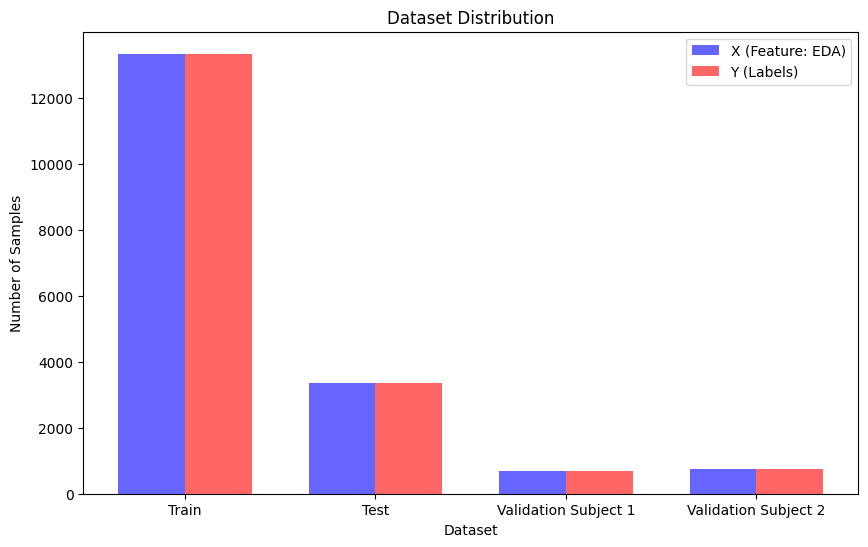

x_train saved successfully to ../data/results/x_train.pkl
y_train saved successfully to ../data/results/y_train.pkl
x_val saved successfully to ../data/results/x_val.pkl
y_val saved successfully to ../data/results/y_val.pkl
x_test_1 saved successfully to ../data/results/x_test_1.pkl
y_test_1 saved successfully to ../data/results/y_test_1.pkl
x_test_2 saved successfully to ../data/results/x_test_2.pkl
y_test_2 saved successfully to ../data/results/y_test_2.pkl


In [171]:
x_train, y_train, x_test, y_test, y_val_subject_1, y_val_subject_2= main()
